# Установка требуемых библиотек

In [ ]:
from google.colab import files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline

from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from google.colab import drive
import time
import seaborn as sns
sns.set_style('darkgrid')

# Подготовка данных

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!rm -R '/content/texts'

In [ ]:
!unzip -q '/content/drive/MyDrive/Lessons/Lesson4/Тексты писателей.zip' -d '/content/texts'

In [ ]:
def readText(fileName):
  f = open(fileName, 'r')
  text = f.read()
  text = text.replace("\n", " ")
  
  return text         

className = ["О. Генри", "Стругацкие", "Булгаков", "Саймак", "Фрай", "Брэдберри"]
nClasses = len(className)

In [ ]:
trainText = []
testText = []

for i in className:
  for j in os.listdir('texts/Тексты писателей'):
    if i in j:
      
      if 'Обучающая' in j:  
        trainText.append(readText('texts/Тексты писателей/' + j))
        print(j, 'добавлен в обучающую выборку')
      if 'Тестовая' in j:
        testText.append(readText('texts/Тексты писателей/' + j)) 
        print(j, 'добавлен в тестовую выборку')
  print()

(О. Генри) Обучающая_50 вместе.txt добавлен в обучающую выборку
(О. Генри) Тестовая_20 вместе.txt добавлен в тестовую выборку

(Стругацкие) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Стругацкие) Тестовая_2 вместе.txt добавлен в тестовую выборку

(Булгаков) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Булгаков) Тестовая_2 вместе.txt добавлен в тестовую выборку

(Клиффорд_Саймак) Тестовая_2 вместе.txt добавлен в тестовую выборку
(Клиффорд_Саймак) Обучающая_5 вместе.txt добавлен в обучающую выборку

(Макс Фрай) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Макс Фрай) Тестовая_2 вместе.txt добавлен в тестовую выборку

(Рэй Брэдберри) Обучающая_22 вместе.txt добавлен в обучающую выборку
(Рэй Брэдберри) Тестовая_8 вместе.txt добавлен в тестовую выборку



In [ ]:
checkData = trainText

# Работа с данными

## Вспомогательные функции

In [ ]:
def getSetFromIndexes(wordIndexes, xLen, step):
  xSample = []
  wordsLen = len(wordIndexes)
  index = 0
  while (index + xLen <= wordsLen):
    xSample.append(wordIndexes[index:index+xLen])
    index += step
  return xSample

In [ ]:
def createSetsMultiClasses(wordIndexes, xLen, step):

  nClasses = len(wordIndexes)
  classesXSamples = []
  for wI in wordIndexes:
    classesXSamples.append(getSetFromIndexes(wI, xLen, step))

  xSamples = []
  ySamples = []
  
  for t in range(nClasses):
    xT = classesXSamples[t]
    for i in range(len(xT)):

      xSamples.append(xT[i])
      ySamples.append(utils.to_categorical(t, nClasses))

  xSamples = np.array(xSamples)
  ySamples = np.array(ySamples)

  
  return (xSamples, ySamples)

In [ ]:
def createTestMultiClasses(wordIndexes, xLen, step, tokenizer):

  nClasses = len(wordIndexes)
  xTest6Classes01 = []
  xTest6Classes = []
  for wI in wordIndexes:
    sample = getSetFromIndexes(wI, xLen, step)
    xTest6Classes.append(sample)
    xTest6Classes01.append(tokenizer.sequences_to_matrix(sample))
  xTest6Classes01 = np.array(xTest6Classes01)
  xTest6Classes = np.array(xTest6Classes)
  
  return xTest6Classes01, xTest6Classes


In [ ]:
def recognizeMultiClass(model, xTest, modelName):
  print("НЕЙРОНКА: ", modelName)
  print('-'*20)
  
  totalSumRec = 0
  
  for i in range(nClasses):
    currPred = model.predict(xTest[i])

    currOut = np.argmax(currPred, axis=1)

    evVal = []
    for j in range(nClasses):
      evVal.append(len(currOut[currOut==j])/len(xTest[i]))

    totalSumRec += len(currOut[currOut==i])
    recognizedClass = np.argmax(evVal)
    
    isRecognized = "Это НЕПРАВИЛЬНЫЙ ответ!"
    if (recognizedClass == i):
      isRecognized = "Это ПРАВИЛЬНЫЙ ответ!"
    str1 = 'Класс: ' + className[i] + " " * (11 - len(className[i])) + str(int(100*evVal[i])) + "% сеть отнесла к классу " + className[recognizedClass]
    print(str1, " " * (55-len(str1)), isRecognized, sep='')
  
  print()
  sumCount = 0
  for i in range(nClasses):
    sumCount += len(xTest[i])
  print("Средний процент распознавания ",
        int(100*totalSumRec/sumCount),
        "%",
        sep='')

  print()
  
  return totalSumRec/sumCount

In [ ]:
# Отображение графика
def showTable(history):
  plt.plot(history.history['accuracy'], 
          label='Доля верных ответов на обучающем наборе')
  plt.plot(history.history['val_accuracy'], 
          label='Доля верных ответов на проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Доля верных ответов')
  plt.legend()
  plt.show()

  plt.plot(history.history['loss'], 
          label='Доля ошибок на обучающем наборе')
  plt.plot(history.history['val_loss'], 
          label='Доля ошибок на проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Доля ошибок ответов')
  plt.legend()
  plt.show()
  

## Основная функция

In [ ]:
def takeData(maxWordsCount=10000, level=False):
  cur_time = time.time() 

  tokenizer = Tokenizer(num_words=maxWordsCount,
                        filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
                        lower=True,
                        split=' ',
                        oov_token='unknown',
                        char_level=False)

  tokenizer.fit_on_texts(trainText)
  print('Время обработки: ', round(time.time() - cur_time, 2), 'c', sep='')

  trainWordIndexes = tokenizer.texts_to_sequences(trainText)
  testWordIndexes = tokenizer.texts_to_sequences(testText)

  # Задаем гиперпараметры для функции
  xLen = 5000
  step = 500

  Test, x2 = createTestMultiClasses(testWordIndexes, xLen, step, tokenizer)

  cur_time = time.time()

  xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step)
  xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)

  print('Время обработки: ', round(time.time() - cur_time, 2), 'c', sep='')

  if level:
    return xTrain, yTrain, xTest, yTest
  
  else:
    cur_time = time.time()
    
    xTrain01 = tokenizer.sequences_to_matrix(xTrain.tolist())
    xTest01 = tokenizer.sequences_to_matrix(xTest.tolist())

    print('Время обработки: ', round(time.time() - cur_time, 2), 'c', sep='')

    return xTrain01, xTest01, yTrain, yTest, Test, x2

## Функция создания модели

In [ ]:
# def createModel(neuronsOneLayers=200, layersN=1, activ="relu"):
#   model01 = Sequential() 
#   model01.add(Dropout(0.1, input_dim=maxWordsCount))
#   model01.add(Dense(350, activation="linear"))
 
#   for i in range(layersN):
#     model01.add(Dropout(0.1))
#     model01.add(Dense(neuronsOneLayers,
#                       activation=activ))
#   model01.add(Dropout(0.1))
#   model01.add(Dense(400, activation=activ))

#   model01.add(Dropout(0.1))
#   model01.add(BatchNormalization())
#   model01.add(Dense(6, activation='softmax'))
#   model01.add(BatchNormalization())
#   model01.compile(optimizer='adam', 
#                 loss='categorical_crossentropy', 
#                 metrics=['accuracy'])

#   model01.summary()

#   return model01

In [ ]:
maxWordsCount = 20000
xTrain, xTest, yTrain, yTest, Test, x2 = takeData(maxWordsCount)

Время обработки: 3.32c


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()


Время обработки: 2.38c
Время обработки: 10.03c


In [ ]:
def createModel():
  model = Sequential()
  model.add(Dropout(0.3, input_dim=maxWordsCount))
  model.add(Dense(100))
  # model.add(Dropout(0.1))
  # model.add(Dense(100))
  
  model.add(Dense(6, activation="softmax"))

  model.compile(optimizer=Adam(lr=0.001),
                loss="categorical_crossentropy",
                metrics=["accuracy"])
  
  model.summary()

  return model

In [ ]:
# add new layer Dense (100) 1 - 90%
# Dense (300) 1 - 88%
# in 1: 1 - 88% , 2 - 89%, 3 - 88%
# in 2: 1 - 86% , 2 - 85%, 3 - 88%
# in 2: 1 - 86% , 2 - 83%, 3 - 88%
# in 2: 1 - 87% , 2 - 75%, 3 - 86%
# in 2: 1 - 88% , 2 - 83%, 3 - 86%
# in 2: 1 - 87% , 2 - 85%, 3 - 87%  change activation(14) relu
# in 2: 1 - 00% , 2 - 00%, 3 - 00%  change activation(14) sigmoid
# in 2: 1 - 86% , 2 - 86%, 3 - 88%  change activation(14) to softmax
# in 2: 1 - 89% , 2 - 89%, 3 - 87%  change maxWordsCount to 20000
# in 2: 1 - 89% , 2 - 87%, 3 - 88%  change neurons to 400 (11)
# in 2: 1 - 89% , 2 - 89%, 3 - 87%  change neurons to 350 (4)
# in 2: 1 - 88% , 2 - 70%, 3 - 80%  repeat
# in 2: 1 - 90% , 2 - 88%, 3 - 88%  ??????
# in 2: 1 - 89% , 2 - 84%, 3 - 87%  add one layer BatchNormalization (12)
# in 2: 1 - 66% , 2 - 43%, 3 - 47%  del layer BatchNormalization (12) 

# Create new create_model()
# 88% add Dropout(0.2) (3)
# 89% change Dropout to 0.4 (3)
# 89% repeat
# 90% change Dropout to 0.3 (2)
# 89% return back & level-down neurons on Dense layer(100) (4)
# 89% repeat
# 89% repeat
# 89% increase the epochs to 40
# 90% increase the epochs to 100
# 91% change learning rate to 0.001
# 90% add vawe with lr=0.0001, epochs = 50, epochs = 50
# 90% change 1-st level lr to 0.01, 2-nd to 0.001
# 83% return back
# 90% add Dense(100)  (5)
# 89% return back add Dropout(0.1) 5
# 90% change maxWordsCount to 20000 
# 91% change xLen to 2000, step to 200
# 93% change xLen to 5000, step to 500
# 95% change xLen to 10000, step to 1000
# 64% go back

## Переменная для хранения точностей

In [ ]:
# constants
epochs = 50
maxWordsCount
print(xTrain.shape)

(3483, 20000)


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_6 (Dropout)          (None, 20000)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)               2000100   
_________________________________________________________________
dense_13 (Dense)             (None, 6)                 606       
Total params: 2,000,706
Trainable params: 2,000,706
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/50
28/28 [==============================] - 2s 75ms/step - loss: 0.2717 - accuracy: 0.9219 - val_loss: 1.0099 - val_accuracy: 0.6316
Epoch 2/50
28/28 [==============================] - 2s 67ms/step - loss: 3.9063e-04 - accuracy: 1.0000 - val_loss: 0.8368 - val_accuracy: 0.6811
Epoch 3/50
28/28 [==============================] - 2s 66ms/step - loss: 3.4057e-05 - accuracy: 1.0000 - val_loss: 0.7709 - val_accuracy: 0.6904
Epoch 4/50
28/28 [==============================] - 2s 67ms/step - loss: 2.8792e-05 - accuracy: 1.0000 - val_loss: 0.7276 - val_accuracy: 0.6966
Epoch 5/50
28/28 [==============================] - 2s 71ms/step - loss: 2.0195e-05 - accuracy: 1.0000 - val_loss: 0.6915 - val_accuracy: 0.7067
Epoch 6/50
28/28 [==============================] - 2s 67ms/step - loss: 1.4130e-05 - accuracy: 1.0000 - val_loss: 0.6691 - val_accuracy: 0.7152
Epoch 7/50
28/28 [==============================] - 2s 67ms/step - loss: 1.6978e-05 - accuracy: 1.0000 - val_loss: 0.6396 - val_accura

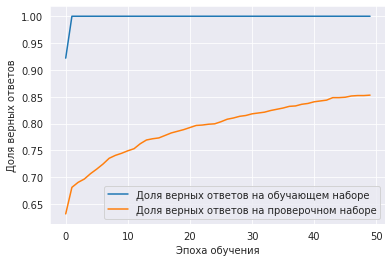

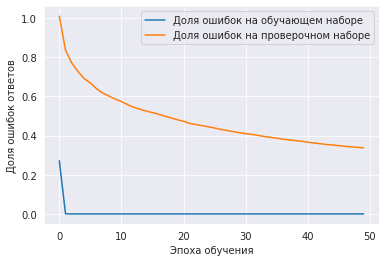

НЕЙРОНКА:  Set of neurons
--------------------
Класс: О. Генри   98% сеть отнесла к классу О. Генри   Это ПРАВИЛЬНЫЙ ответ!
Класс: Стругацкие 92% сеть отнесла к классу Стругацкие Это ПРАВИЛЬНЫЙ ответ!
Класс: Булгаков   58% сеть отнесла к классу Булгаков   Это ПРАВИЛЬНЫЙ ответ!
Класс: Саймак     81% сеть отнесла к классу Саймак     Это ПРАВИЛЬНЫЙ ответ!
Класс: Фрай       97% сеть отнесла к классу Фрай       Это ПРАВИЛЬНЫЙ ответ!
Класс: Брэдберри  83% сеть отнесла к классу Брэдберри  Это ПРАВИЛЬНЫЙ ответ!

Средний процент распознавания 85%

Epoch 1/50
28/28 [==============================] - 2s 73ms/step - loss: 5.5997e-07 - accuracy: 1.0000 - val_loss: 0.2538 - val_accuracy: 0.8885
Epoch 2/50
28/28 [==============================] - 2s 67ms/step - loss: 3.8366e-07 - accuracy: 1.0000 - val_loss: 0.1597 - val_accuracy: 0.9334
Epoch 3/50
28/28 [==============================] - 2s 66ms/step - loss: 1.9019e-07 - accuracy: 1.0000 - val_loss: 0.1392 - val_accuracy: 0.9505
Epoch 4/50
28/28 [==

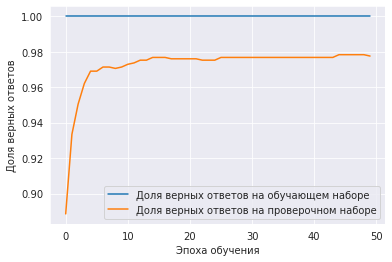

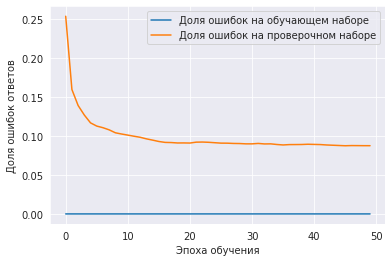

НЕЙРОНКА:  Set of neurons
--------------------
Класс: О. Генри   100% сеть отнесла к классу О. Генри  Это ПРАВИЛЬНЫЙ ответ!
Класс: Стругацкие 92% сеть отнесла к классу Стругацкие Это ПРАВИЛЬНЫЙ ответ!
Класс: Булгаков   99% сеть отнесла к классу Булгаков   Это ПРАВИЛЬНЫЙ ответ!
Класс: Саймак     100% сеть отнесла к классу Саймак    Это ПРАВИЛЬНЫЙ ответ!
Класс: Фрай       96% сеть отнесла к классу Фрай       Это ПРАВИЛЬНЫЙ ответ!
Класс: Брэдберри  100% сеть отнесла к классу Брэдберри Это ПРАВИЛЬНЫЙ ответ!

Средний процент распознавания 97%



0.9775541795665634

In [ ]:
model = createModel()
history = model.fit(xTrain,
                    yTrain,
                    epochs=epochs,
                    batch_size=128,
                    validation_data=(xTest, yTest),
                    verbose=1)

showTable(history)
recognizeMultiClass(model, Test, "Set of neurons")

model.compile(optimizer=Adam(lr=0.0001),
              metrics=["accuracy"],
              loss="categorical_crossentropy")

history = model.fit(xTrain,
                    yTrain,
                    epochs=epochs,
                    batch_size=128,
                    validation_data=(xTest, yTest),
                    verbose=1)

showTable(history)
recognizeMultiClass(model, Test, "Set of neurons")

